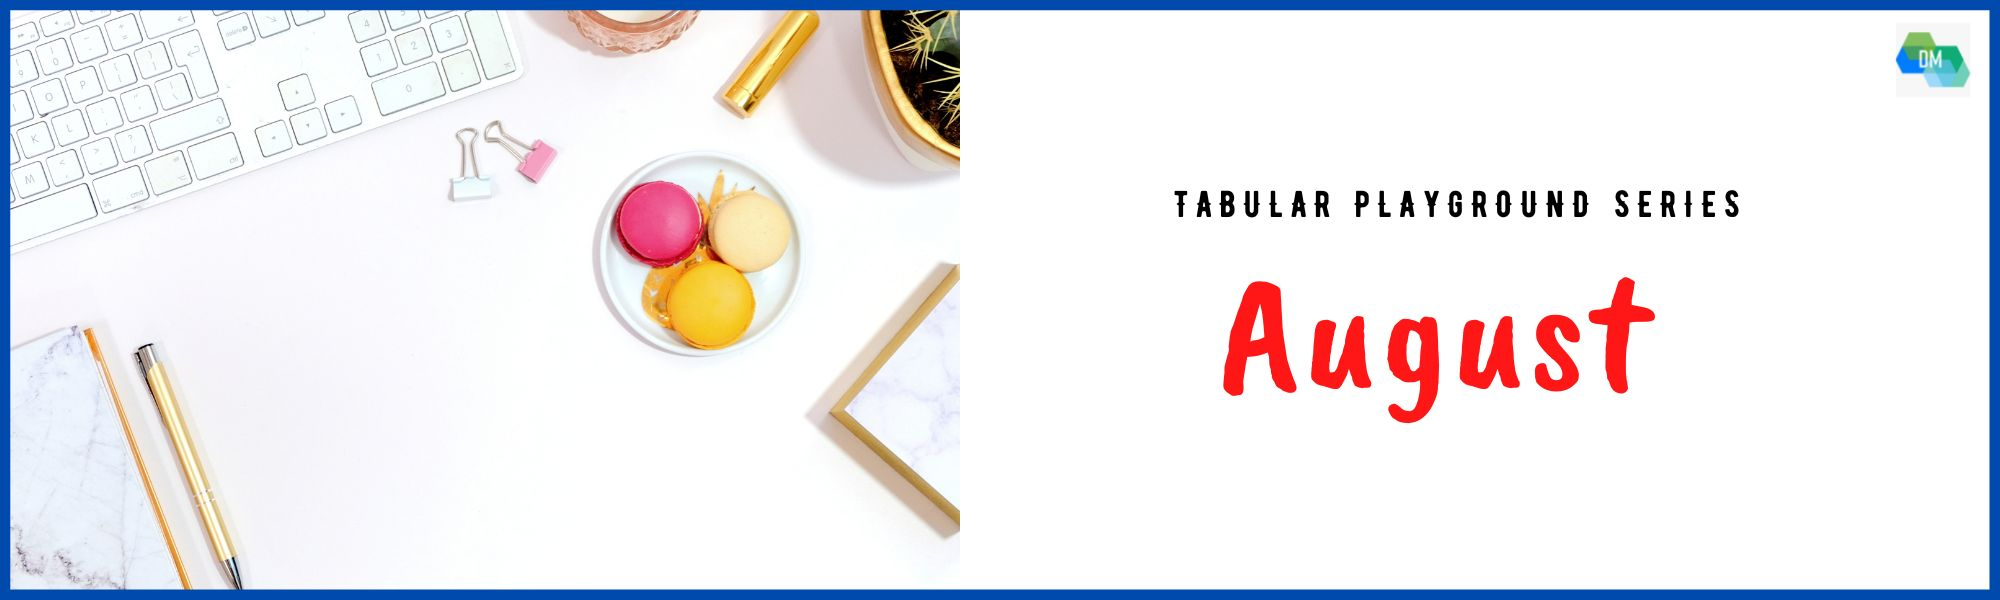

<p style="font-family: Arials; font-size: 18px;text-align: center;; font-style: normal;line-height:1.3">For this challenge, Your task is to use the data to predict individual product failures of new codes with their individual lab test results. </p>

<p style="font-family: Arials; font-size: 18px;text-align: center;; font-style: normal;line-height:1.3">The data represents the results of a large product testing study. For each product_code you are given a number of product attributes (fixed for the code) as well as a number of measurement values for each individual product, representing various lab testing methods. Each product is used in a simulated real-world environment experiment, and and absorbs a certain amount of fluid (loading) to see whether or not it fails. </p>

**Observations on this TPS dataset:**
- `failure` column is the target variable 
- `Train` dataset has `26,570` rows and `26` columns which contains`24` features, `1` target variable `failure` and `1` column of `id`
- `Test` dataset has `20,775` rows and `25` columns which contains`24` features with`1` column of `id`
- There are missing values in train and test dataset

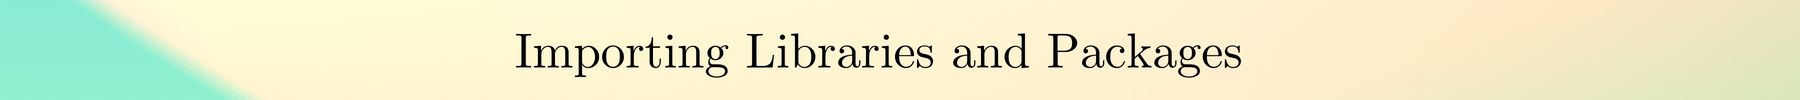

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
import plotly.graph_objects as go
import lightgbm as lgbm  
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

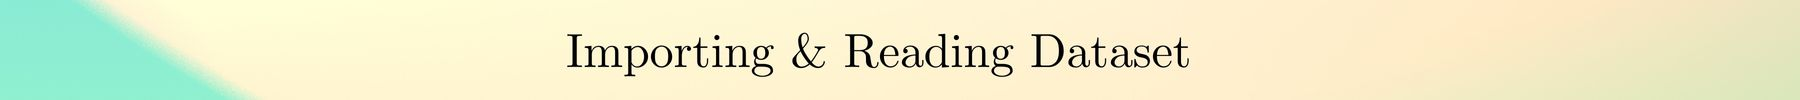

In [2]:
df_train= pd.read_csv("../input/tabular-playground-series-aug-2022/train.csv")
df_test= pd.read_csv("../input/tabular-playground-series-aug-2022/test.csv")
df_subm= pd.read_csv("../input/tabular-playground-series-aug-2022/sample_submission.csv")

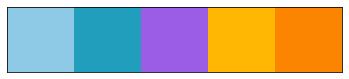

In [3]:
#Custom Color Palette 🎨
custom_colors = ["#8ecae6","#219ebc","#9b5de5","#ffb703","#fb8500"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))
sns.palplot(sns.color_palette(custom_colors),size=1.2)
plt.tick_params(axis='both', labelsize=0, length = 0)

In [4]:
df_train_row_count, df_train_column_count = df_train.shape
print('Total number of rows:', df_train_row_count) 
print('Total number of columns:', df_train_column_count)

Total number of rows: 26570
Total number of columns: 26


In [5]:
df_test_row_count, df_test_column_count = df_test.shape
print('Total number of rows:', df_test_row_count)
print('Total number of columns:', df_test_column_count) 

Total number of rows: 20775
Total number of columns: 25


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26570 entries, 0 to 26569
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              26570 non-null  int64  
 1   product_code    26570 non-null  object 
 2   loading         26320 non-null  float64
 3   attribute_0     26570 non-null  object 
 4   attribute_1     26570 non-null  object 
 5   attribute_2     26570 non-null  int64  
 6   attribute_3     26570 non-null  int64  
 7   measurement_0   26570 non-null  int64  
 8   measurement_1   26570 non-null  int64  
 9   measurement_2   26570 non-null  int64  
 10  measurement_3   26189 non-null  float64
 11  measurement_4   26032 non-null  float64
 12  measurement_5   25894 non-null  float64
 13  measurement_6   25774 non-null  float64
 14  measurement_7   25633 non-null  float64
 15  measurement_8   25522 non-null  float64
 16  measurement_9   25343 non-null  float64
 17  measurement_10  25270 non-null 

In [7]:
df_train.describe()

,id,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
count,26570.000000,26320.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26189.000000,26032.000000,25894.000000,...,25343.000000,25270.000000,25102.000000,24969.000000,24796.000000,24696.000000,24561.000000,24460.000000,24286.000000,26570.000000
mean,13284.500000,127.826233,6.754046,7.240459,7.415883,8.232518,6.256568,17.791528,11.731988,17.127804,...,11.430725,16.117711,19.172085,11.702464,15.652904,16.048444,14.995554,16.460727,701.269059,0.212608
std,7670.242662,39.030020,1.471852,1.456493,4.116690,4.199401,3.309109,1.001200,0.996085,0.996414,...,0.999137,1.405978,1.520785,1.488838,1.155247,1.491923,1.549226,1.708935,123.304161,0.409160
min,0.000000,33.160000,5.000000,5.000000,0.000000,0.000000,0.000000,13.968000,8.008000,12.073000,...,7.537000,9.323000,12.461000,5.167000,10.890000,9.140000,9.104000,9.701000,196.787000,0.000000
25%,6642.250000,99.987500,6.000000,6.000000,4.000000,5.000000,4.000000,17.117000,11.051000,16.443000,...,10.757000,15.209000,18.170000,10.703000,14.890000,15.057000,13.957000,15.268000,618.961500,0.000000
50%,13284.500000,122.390000,6.000000,8.000000,7.000000,8.000000,6.000000,17.787000,11.733000,17.132000,...,11.430000,16.127000,19.211500,11.717000,15.628500,16.040000,14.969000,16.436000,701.024500,0.000000
75%,19926.750000,149.152500,8.000000,8.000000,10.000000,11.000000,8.000000,18.469000,12.410000,17.805000,...,12.102000,17.025000,20.207000,12.709000,16.374000,17.082000,16.018000,17.628000,784.090250,0.000000
max,26569.000000,385.860000,9.000000,9.000000,29.000000,29.000000,24.000000,21.499000,16.484000,21.425000,...,15.412000,22.479000,25.640000,17.663000,22.713000,22.303000,21.626000,24.094000,1312.794000,1.000000


In [8]:
feat_float = df_train.select_dtypes(np.float).columns
feat_int = df_train.select_dtypes(np.int).columns
feat_object = df_train.select_dtypes(np.object).columns
print("Float Features:",feat_float)
print("Integer Features:",feat_int)
print("Object Features:",feat_object)

Float Features: Index(['loading', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13',
       'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17'],
      dtype='object')
Integer Features: Index(['id', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1',
       'measurement_2', 'failure'],
      dtype='object')
Object Features: Index(['product_code', 'attribute_0', 'attribute_1'], dtype='object')


Text(0.5, 1.0, 'Test Features')

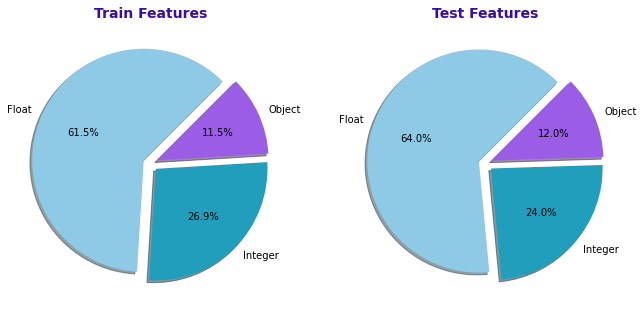

In [9]:
test_float = df_test.select_dtypes(np.float).columns
test_int = df_test.select_dtypes(np.int).columns
test_object = df_test.select_dtypes(np.object).columns

labels_1=['Float', 'Integer','Object',]
values_1= [len(feat_float), len(feat_int),len(feat_object)]
labels_2=['Float', 'Integer','Object',]
values_2= [len(test_float), len(test_int),len(test_object)]

fig, ax = plt.subplots(1,2, figsize = (11,11))
((ax1, ax2)) = ax

labels = labels_1
values = values_1
ax1.pie(x=values, labels=labels, autopct="%1.1f%%",colors=custom_colors,shadow=True, 
        startangle=45, explode=[0.065, 0.07,0.065])
ax1.set_title("Train Features", fontdict={'fontsize': 14},fontweight ='bold',color="#3a0ca3")

labels = labels_2
values = values_2
ax2.pie(x=values, labels=labels, autopct="%1.1f%%",colors=custom_colors,shadow=True, 
        startangle=45, explode=[0.06, 0.07,0.065])
ax2.set_title("Test Features", fontdict={'fontsize': 14},fontweight ='bold',color="#3a0ca3")

In [10]:
df_train.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


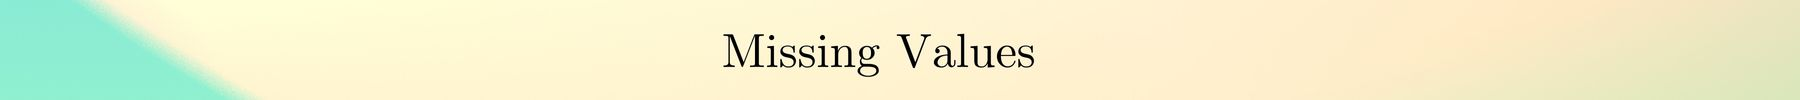

In [11]:
df_train.isna().sum()

id                   0
product_code         0
loading            250
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      381
measurement_4      538
measurement_5      676
measurement_6      796
measurement_7      937
measurement_8     1048
measurement_9     1227
measurement_10    1300
measurement_11    1468
measurement_12    1601
measurement_13    1774
measurement_14    1874
measurement_15    2009
measurement_16    2110
measurement_17    2284
failure              0
dtype: int64

In [12]:
df_test.isna().sum()

id                   0
product_code         0
loading            223
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      329
measurement_4      409
measurement_5      508
measurement_6      624
measurement_7      720
measurement_8      846
measurement_9      904
measurement_10    1067
measurement_11    1136
measurement_12    1240
measurement_13    1303
measurement_14    1440
measurement_15    1542
measurement_16    1678
measurement_17    1740
dtype: int64

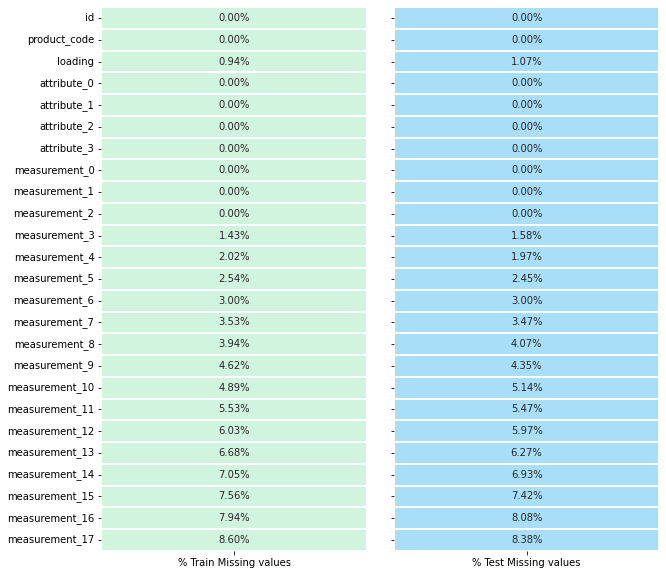

In [13]:
background_color = 'white'
missing = pd.DataFrame(columns=['% Train Missing values'],data=df_train.isnull().sum()/len(df_train))
missing.drop(['failure'],inplace=True)
missing_tst = pd.DataFrame(columns=['% Test Missing values'],data=df_test.isnull().sum()/len(df_test))
fig = plt.figure(figsize=(10, 10),facecolor=background_color)
gs = fig.add_gridspec(1, 2)
gs.update(wspace=0.1, hspace=0.1)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
for s in ["right", "top","bottom","left"]:
    ax0.spines[s].set_visible(False)
    ax1.spines[s].set_visible(False)
tr_cr=["#d0f4de"]
tr_cr2=["#a9def9"]
sns.heatmap(missing,cbar=False,annot=True,fmt=".2%", linewidths=2,cmap=tr_cr,vmax=1, ax=ax0)
sns.heatmap(missing_tst,cbar=False,annot=True,fmt=".2%", linewidths=2,cmap=tr_cr2,vmax=1, ax=ax1)
ax1.set_yticklabels([])
plt.show()

In [14]:
print ("Unique values are:\n",df_train.nunique())

Unique values are:
 id                26570
product_code          5
loading           11950
attribute_0           2
attribute_1           3
attribute_2           4
attribute_3           4
measurement_0        29
measurement_1        30
measurement_2        25
measurement_3      4721
measurement_4      4692
measurement_5      4671
measurement_6      4704
measurement_7      4734
measurement_8      4713
measurement_9      4708
measurement_10     6177
measurement_11     6526
measurement_12     6392
measurement_13     5271
measurement_14     6389
measurement_15     6577
measurement_16     7035
measurement_17    23612
failure               2
dtype: int64


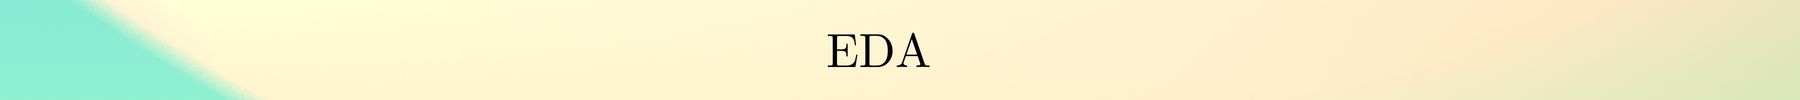

In [15]:
target_class = pd.DataFrame({'count': df_train.failure.value_counts(),
                             'percentage': df_train['failure'].value_counts() / df_train.shape[0] * 100
})

In [16]:
target_class 

,count,percentage
0,20921,78.73918
1,5649,21.26082


In [17]:
fig = go.Figure(data=[go.Pie(labels=df_train.failure, hole=0.6)])
fig.update_traces(hoverinfo='label+percent',marker = dict(colors =["#fec89a","#e4c1f9"]),
                  title = dict(text = 'Failure Distribution'))
fig.update_traces(textposition='outside', textinfo='label')
fig.show()

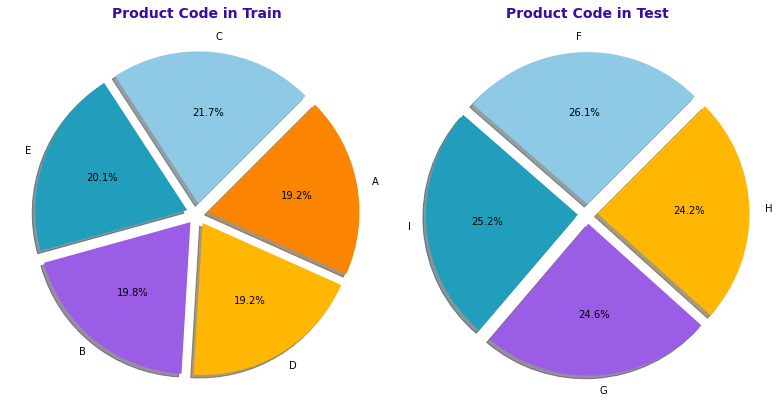

In [18]:
fig, ax = plt.subplots(1,2, figsize = (11,11))
((ax1, ax2)) = ax

labels = ["C","E","B","D","A"]
values = df_train['product_code'].value_counts().tolist()
ax1.pie(x=values, labels=labels, autopct="%1.1f%%",colors=custom_colors,shadow=True, 
        startangle=45, explode=[0.07, 0.07,0.07,0.07,0.07])
ax1.set_title("Product Code in Train", fontdict={'fontsize': 14},fontweight ='bold',color="#3a0ca3")

labels = ["F","I","G","H"]
values = df_test['product_code'].value_counts().tolist()
ax2.pie(x=values, labels=labels, autopct="%1.1f%%",colors=custom_colors,shadow=True, 
        startangle=45, explode=[0.065, 0.065,0.065,0.065])
ax2.set_title("Product Code in Test", fontdict={'fontsize': 14},fontweight ='bold',color="#3a0ca3")

plt.tight_layout()
plt.show()

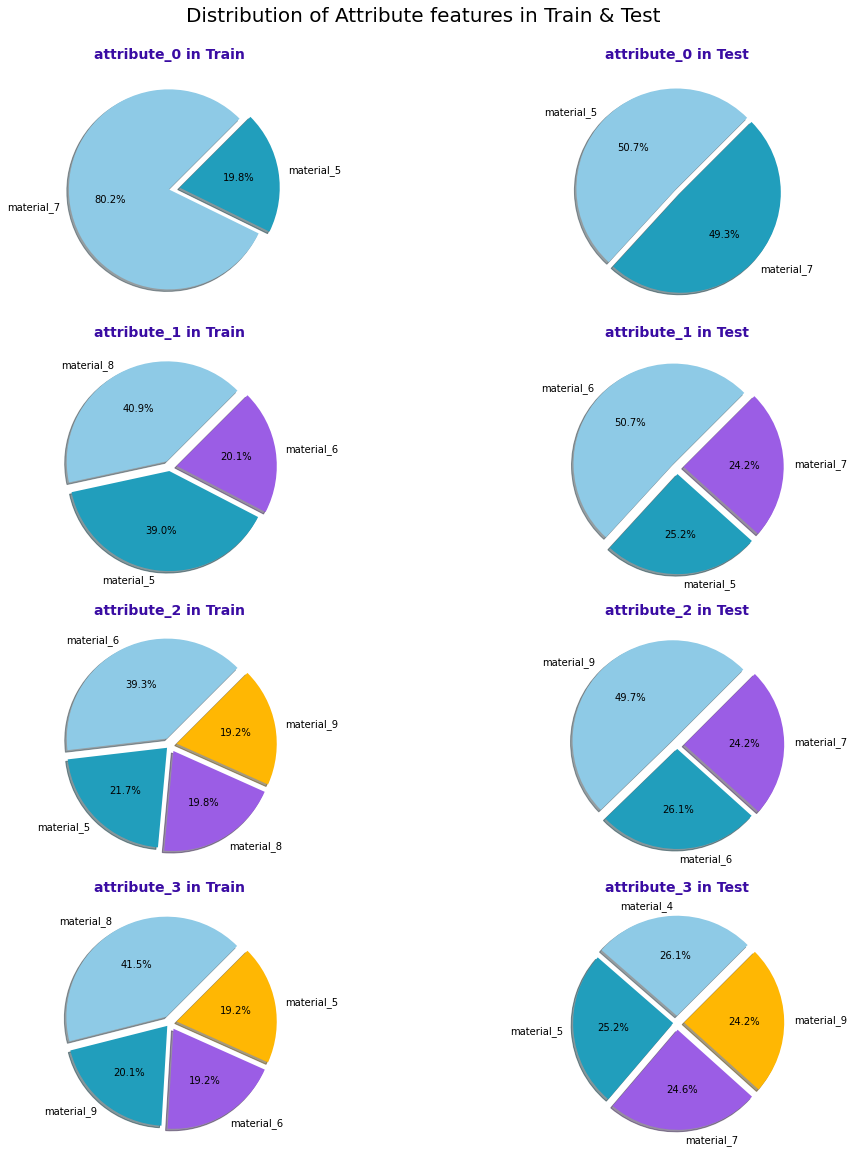

In [19]:
fig, ax = plt.subplots(4,2, figsize = (16,16))
((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = ax

labels = df_train['attribute_0'].value_counts().index.tolist()[:2]
values = df_train['attribute_0'].value_counts().tolist()[:2]
ax1.pie(x=values, labels=labels, autopct="%1.1f%%",colors=custom_colors,shadow=True, startangle=45,
        explode=[0.01, 0.1])
ax1.set_title("attribute_0 in Train", fontdict={'fontsize': 14},fontweight ='bold',color="#3a0ca3")

labels = df_test['attribute_0'].value_counts().index.tolist()[:2]
values = df_test['attribute_0'].value_counts().tolist()[:2]
ax2.pie(x=values, labels=labels, autopct="%1.1f%%",colors=custom_colors,shadow=True, startangle=45,
        explode=[0.01, 0.05])
ax2.set_title("attribute_0 in Test", fontdict={'fontsize': 14},fontweight ='bold',color="#3a0ca3")


labels = ["material_8", "material_5","material_6"]
values = df_train['attribute_1'].value_counts().tolist()
ax3.pie(x=values, labels=labels, autopct="%1.1f%%",colors=custom_colors,shadow=True, startangle=45,
        explode=[0.065, 0.04,0.07])
ax3.set_title("attribute_1 in Train", fontdict={'fontsize': 14},fontweight ='bold',color="#3a0ca3")

labels = ["material_6","material_5","material_7"]
values = df_test['attribute_1'].value_counts().tolist()
ax4.pie(x=values, labels=labels, autopct="%1.1f%%",colors=custom_colors,shadow=True, startangle=45,
        explode=[0.05, 0.07,0.065])
ax4.set_title("attribute_1 in Test", fontdict={'fontsize': 14},fontweight ='bold',color="#3a0ca3")

labels = ["material_6","material_5","material_8","material_9"]
values = df_train['attribute_2'].value_counts().tolist()
ax5.pie(x=values, labels=labels, autopct="%1.1f%%",colors=custom_colors,shadow=True, 
        startangle=45, explode=[0.07, 0.04,0.07,0.07])
ax5.set_title("attribute_2 in Train", fontdict={'fontsize': 14},fontweight ='bold',color="#3a0ca3")

labels = ["material_9","material_6","material_7"]
values = df_test['attribute_2'].value_counts().tolist()
ax6.pie(x=values, labels=labels, autopct="%1.1f%%",colors=custom_colors,shadow=True, 
        startangle=45, explode=[0.065, 0.04,0.07])
ax6.set_title("attribute_2 in Test", fontdict={'fontsize': 14},fontweight ='bold',color="#3a0ca3")

labels = ["material_8","material_9","material_6","material_5"]
values = df_train['attribute_3'].value_counts().tolist()
ax7.pie(x=values, labels=labels, autopct="%1.1f%%",colors=custom_colors,shadow=True, 
        startangle=45, explode=[0.07, 0.04,0.07,0.07])
ax7.set_title("attribute_3 in Train", fontdict={'fontsize': 14},fontweight ='bold',color="#3a0ca3")

labels = ["material_4","material_5","material_7","material_9"]
values = df_test['attribute_3'].value_counts().tolist()
ax8.pie(x=values, labels=labels, autopct="%1.1f%%",colors=custom_colors,shadow=True, 
        startangle=45, explode=[0.07, 0.04,0.07,0.07])
ax8.set_title("attribute_3 in Test", fontdict={'fontsize': 14},fontweight ='bold',color="#3a0ca3")
fig.suptitle('Distribution of Attribute features in Train & Test', fontsize = 20, x = 0.5, y = 1)
plt.tight_layout()
plt.show()

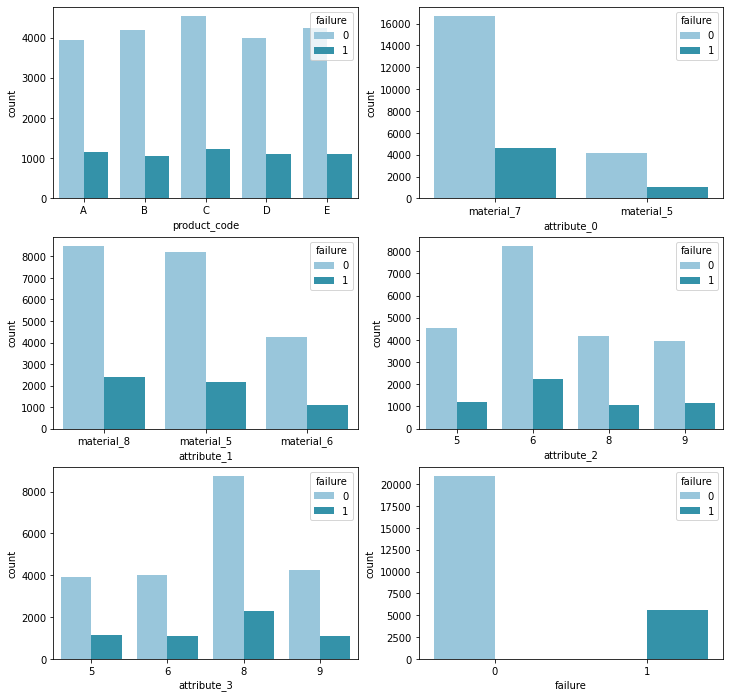

In [20]:
df_st=['product_code','attribute_0','attribute_1','attribute_2','attribute_3','failure']
fig, axs = plt.subplots(3, 2, figsize=(12,12))
axs = axs.flatten()
for i, col_name in enumerate(df_st):
    sns.countplot(x=col_name, data=df_train, ax=axs[i], hue =df_train['failure'],palette=custom_colors)

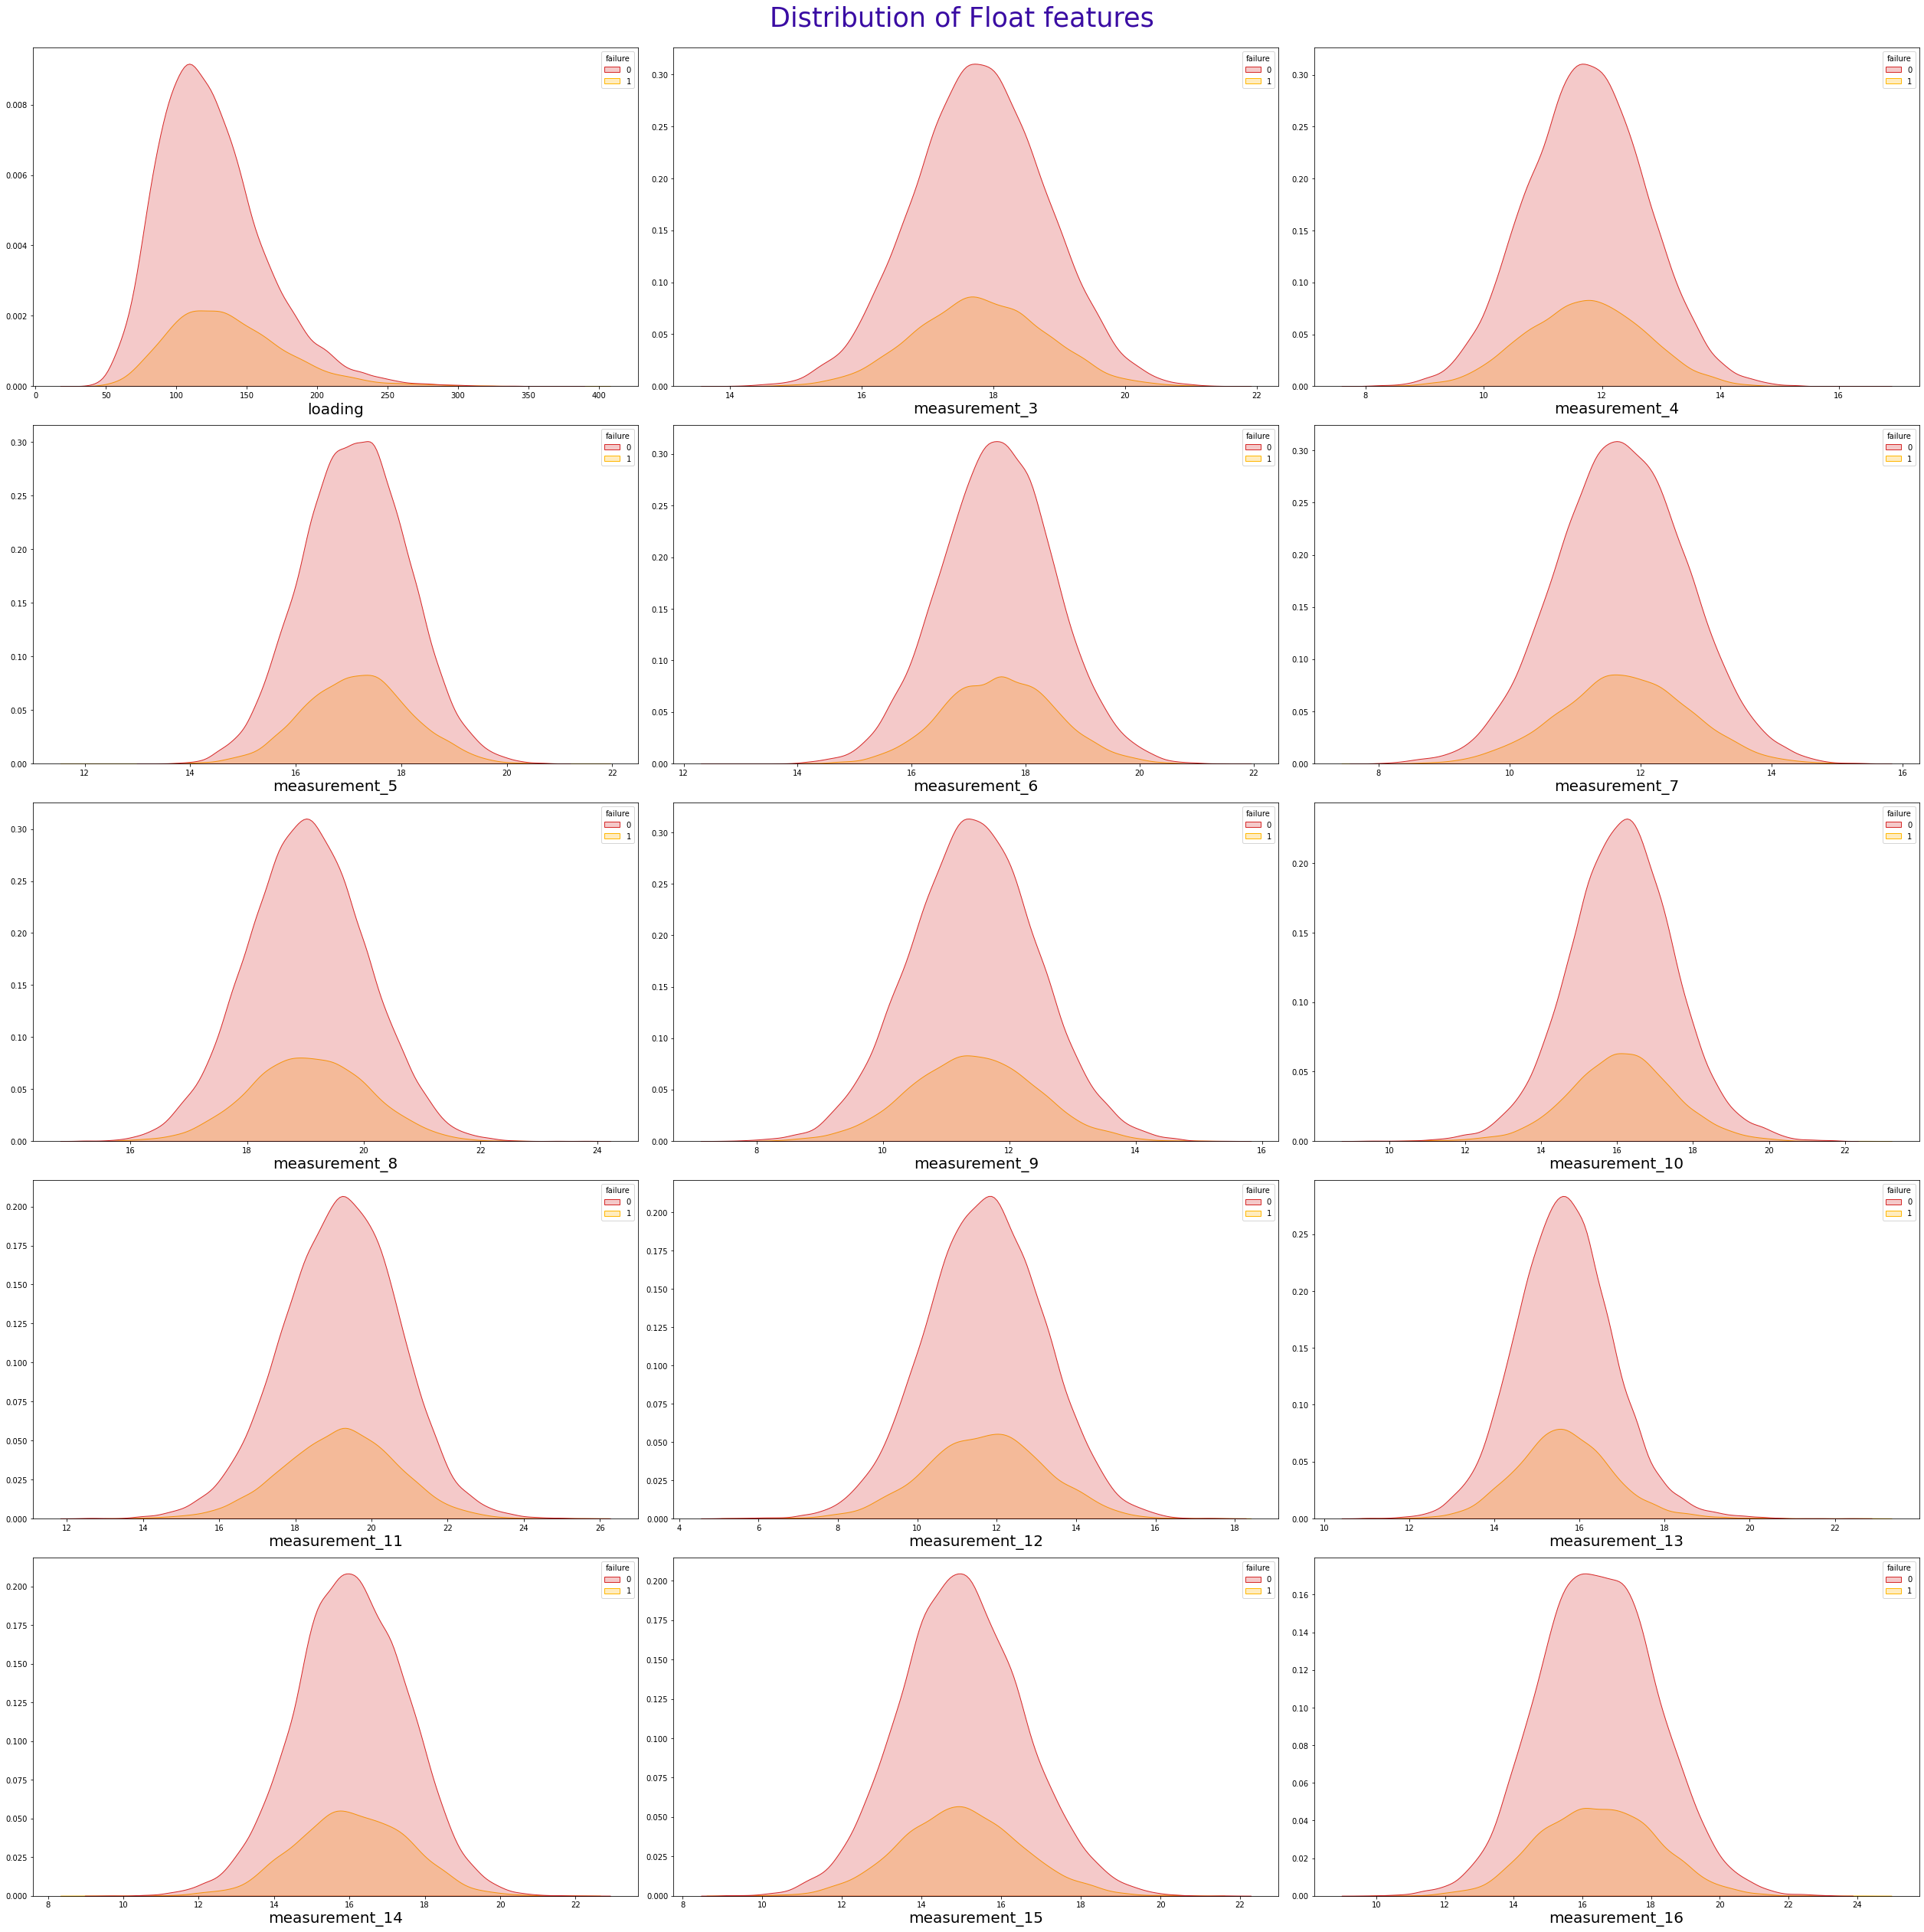

In [21]:
fig, axes = plt.subplots(5, 3, figsize = (35,35))
for i, ax in enumerate(axes.reshape(-1)):
    if i < len(feat_float) - 1:
        sns.kdeplot(x = feat_float[i], hue='failure', data = df_train, fill = True, ax = ax, palette = ["#d62828","#ffb703"])
        ax.tick_params()
        ax.xaxis.get_label().set_fontsize(20)
        ax.set_ylabel('')
fig.suptitle('Distribution of Float features', color="#3a0ca3",fontsize = 35, x = 0.5, y = 1)
plt.tight_layout()
plt.show()

In [22]:
df_train.drop(columns = 'id', inplace = True)
df_test.drop(columns = 'id', inplace = True)

Text(0.5, 1, 'Features correlation in Train')

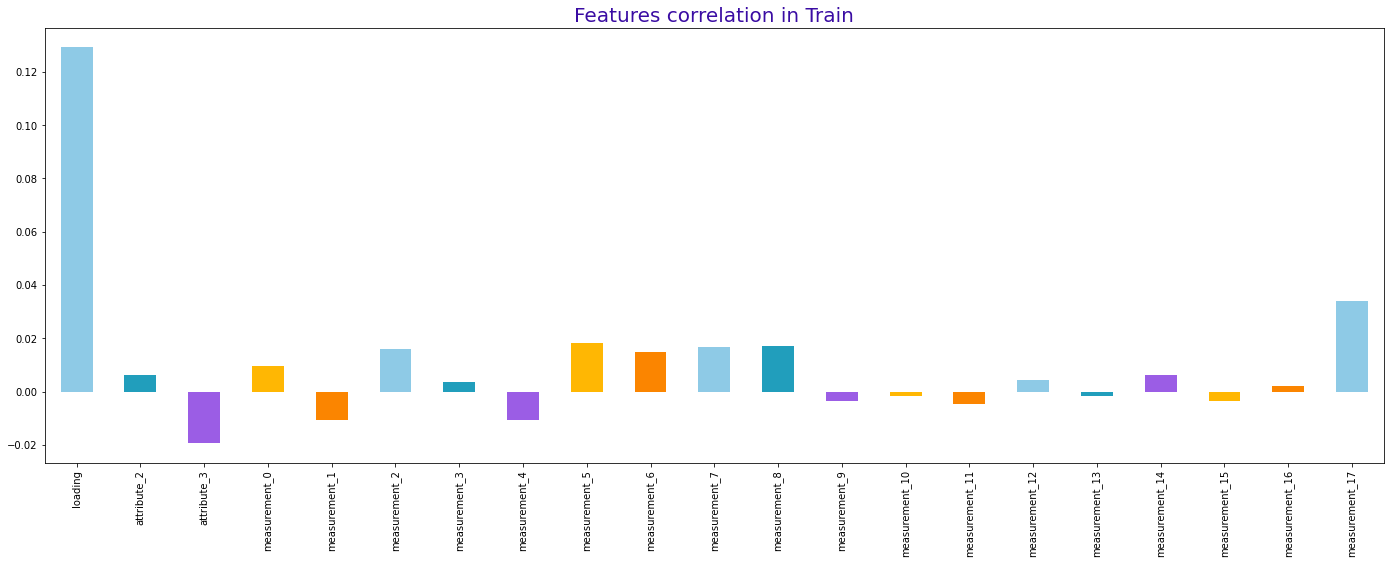

In [23]:
corr_feat = df_train.corr()
plt.figure(figsize=(24,8))
corr_feat["failure"][:-1].plot(kind="bar",color=custom_colors)
plt.title("Features correlation in Train", color="#3a0ca3",fontsize = 20, x = 0.5, y = 1)

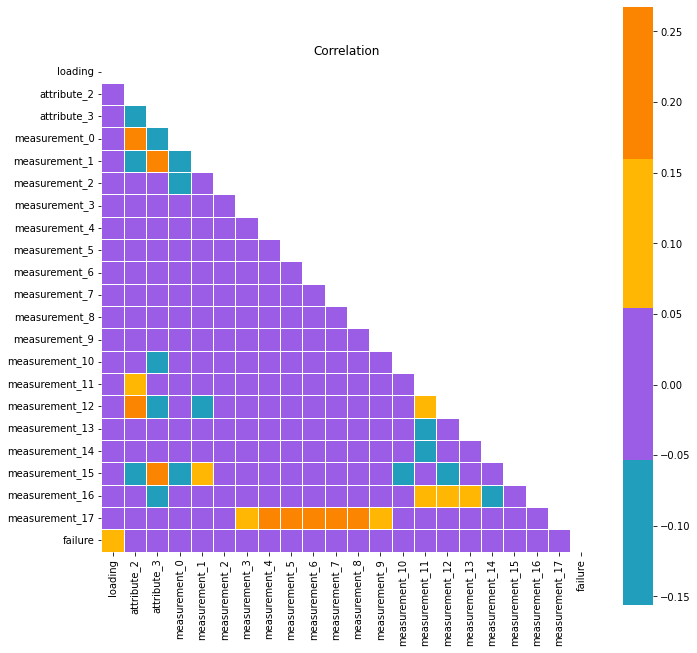

In [24]:
plt.figure(figsize=(11,11))
corr=df_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap=custom_colors, robust=True, center=0,square=True, linewidths=.6)
plt.title('Correlation')
plt.show()

In [25]:
imputer_num = SimpleImputer(strategy="mean")
imputer_num.fit(df_train[feat_float])
df_train[feat_float] = imputer_num.transform(df_train[feat_float])
df_test[feat_float] = imputer_num.transform(df_test[feat_float])

In [26]:
label_encoder = LabelEncoder()
df_train_enc = df_train.copy()
df_test_enc = df_test.copy()

for col in feat_object:
        df_train_enc[col] = label_encoder.fit_transform(df_train[col])
        df_test_enc[col] = label_encoder.fit_transform(df_test[col]) 
        
df_train = df_train_enc
df_test = df_test_enc

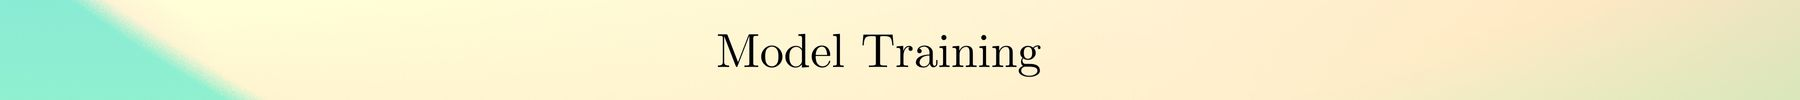

In [27]:
# define dataset
X = df_train.drop(['failure'], axis=1)
y = df_train['failure']

In [28]:
from sklearn.model_selection import train_test_split

# creating dataset split for prediction
X_train, X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=42) # 80-20 split

# Checking split 
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (21256, 24)
y_train: (21256,)
X_test: (5314, 24)
y_test: (5314,)


Logistic Regression

In [29]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
model = LogisticRegression(penalty='l1', solver = 'liblinear', C= 0.01,class_weight = 'balanced',
                              max_iter=200, tol=0.0001, n_jobs=-1, random_state=123)

model.fit(X_train,y_train)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=200, n_jobs=-1,
                   penalty='l1', random_state=123, solver='liblinear')

In [30]:
y_pred=model.predict_proba(df_test)

In [31]:
y_pred

array([[0.49781127, 0.50218873],
       [0.56488859, 0.43511141],
       [0.52567045, 0.47432955],
       ...,
       [0.61682203, 0.38317797],
       [0.4866978 , 0.5133022 ],
       [0.56792926, 0.43207074]])

In [32]:
df_subm['failure'] = y_pred[:,1]

In [33]:
df_subm.to_csv('submission_lr.csv',index=False)
df_subm

,id,failure
0,26570,0.502189
1,26571,0.435111
2,26572,0.474330
3,26573,0.483288
4,26574,0.668783
...,...,...
20770,47340,0.527011
20771,47341,0.425071
20772,47342,0.383178
20773,47343,0.513302


LGBM

In [34]:
model2 =  lgbm.LGBMClassifier(objective= 'binary',learning_rate = 0.05, max_depth = 3, 
                        n_estimators=500)
model2.fit(X_train,y_train)

LGBMClassifier(learning_rate=0.05, max_depth=3, n_estimators=500,
               objective='binary')

In [35]:
y_pred1=model2.predict_proba(df_test)

In [36]:
df_subm['failure']=y_pred[:,1]

In [37]:
df_subm.to_csv('submission_lgbm.csv',index=False)
df_subm

,id,failure
0,26570,0.502189
1,26571,0.435111
2,26572,0.474330
3,26573,0.483288
4,26574,0.668783
...,...,...
20770,47340,0.527011
20771,47341,0.425071
20772,47342,0.383178
20773,47343,0.513302


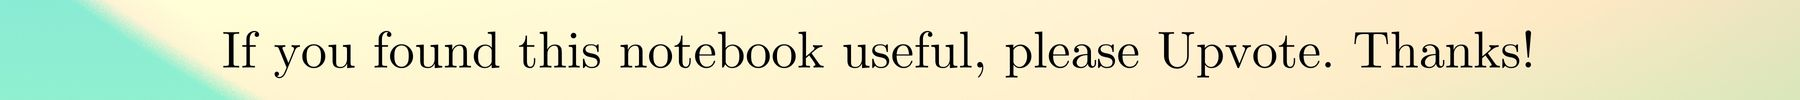